In [22]:
import pandas as pd
import numpy as np

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill().to_frame()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

temp_train, temp_test = temp.iloc[:-5000].values.reshape(1, -1)[0], temp.iloc[-5000:].values.reshape(1, -1)[0]

In [23]:
temp_test

array([16.8, 13.4, 12.3, ...,  3.3,  1. ,  0.6])

In [24]:
X_train = np.array([temp_train[i:i+13] for i in range(0, 50400, 3)])
Y_train = np.array([temp_train[i+13] for i in range(0, 50400, 3)])
X_test = np.array([temp_test[i:i+13] for i in range(0, 4980, 3)])
Y_test = np.array([temp_test[i+13] for i in range(0, 4980, 3)])

In [17]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators = 200,
                             n_jobs=-1)
regr.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [18]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return np.sqrt(s / n) 

In [26]:
l2_improved(regr.predict(X_test), Y_test, [(x % 8) * 3 for x in range(13, 5000, 3)])

1.2843029166328017

In [30]:
from sklearn.ensemble import RandomForestRegressor

for k in [4, 8, 16, 23, 32]:
    X_train = np.array([temp_train[i:i+k] for i in range(0, 50000-k, 3)])
    Y_train = np.array([temp_train[i+k] for i in range(0, 50000-k, 3)])
    X_test = np.array([temp_test[i:i+k] for i in range(0, 5000-k, 1)])
    Y_test = np.array([temp_test[i+k] for i in range(0, 5000-k, 1)])

    print(f"Обучение модели для k={k}...")
    regr = RandomForestRegressor(n_estimators = 100,
                             n_jobs=-1)
    regr.fit(X_train, Y_train)
    print(f"Полученная метрика: {l2_improved(regr.predict(X_test), Y_test, [(x % 8) * 3 for x in list(range(k, 5000))])}", end='\n\n')

Обучение модели для k=4...
Полученная метрика: 1.5150560247377245

Обучение модели для k=8...
Полученная метрика: 1.3285864011800734

Обучение модели для k=16...
Полученная метрика: 1.28960512188931

Обучение модели для k=23...
Полученная метрика: 1.2823940539275391

Обучение модели для k=32...
Полученная метрика: 1.2816321147321288



In [37]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

errors2d = []
for k in [4, 8, 16, 32]:
    X_train = np.array([temp_train[i:i+k] for i in range(0, 50000-k, 3)])
    Y_train = np.array([temp_train[i+k] for i in range(0, 50000-k, 3)])
    X_test = np.array([temp_test[i:i+k] for i in range(0, 4975-k, 1)])
    Y_test = np.array([temp_test[i+k] for i in range(0, 4975-k, 1)])

    print(f"Обучение модели для k={k}...")
    regr = RandomForestRegressor(n_estimators = 100,
                                n_jobs=-1)
    regr.fit(X_train, Y_train)
    errors = []

    for j in range(24):
        result = regr.predict(X_test)
        errors.append(l2_improved(result, Y_test, [((x + j) % 8) * 3 for x in list(range(k, 5000))]))

        X_test = np.concatenate((X_test[:,1:], result.reshape(-1, 1)), axis=1)
        Y_test = np.array([temp_test[i+k] for i in range(j + 1, 4975+j-k+1, 1)])
    
    errors2d.append(errors)

Обучение модели для k=4...
Обучение модели для k=8...
Обучение модели для k=16...
Обучение модели для k=32...


In [42]:
errors_arima = [1.398943958112404,
 1.954334177565147,
 2.326857084232254,
 2.5746966935799356,
 2.7693452709431945,
 2.8621212888566303,
 2.982697914144897,
 3.183010958581057,
 3.440759249346851,
 3.612705383092941,
 3.731824087148361,
 3.7039403738128374,
 3.6878692452430584,
 3.797037028858935,
 3.9696905743434177,
 4.141327882484276,
 4.296106362502797,
 4.454907678548909,
 4.475505731986162,
 4.426781713841289,
 4.3638058001347195,
 4.406177101760469,
 4.486027679613066,
 4.629906797962586]
errors_naive = [1.4397780182050635, 2.3083268163831785, 3.0005590439356684, 3.4464083445843094, 3.5343083326293887, 3.450806992828847, 3.3459484850706747, 3.402772319273203, 3.6361483346044765, 3.948508871997673, 4.298853263008481, 4.5630259197489895, 4.615051857565328, 4.55103620640407, 4.479715994589277, 4.512580692266964, 4.634599339409483, 4.817826161745919, 5.058715571267133, 5.256200029814936, 5.262736502585181, 5.18633236475787, 5.0960702480490525, 5.10072170495821]

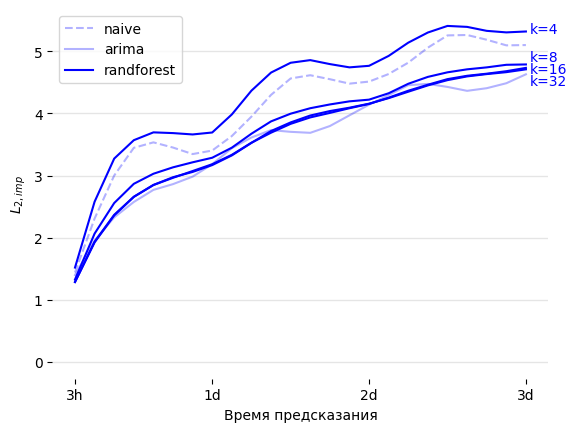

In [43]:
x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(6):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, errors_naive, color="blue", alpha=0.3, label="naive", ls="--")
plt.plot(x_values, errors_arima, color="blue", alpha=0.3, label="arima")
plt.plot(x_values, errors2d[0], color="blue",label="randforest")
plt.plot(x_values, errors2d[1], color="blue")
plt.plot(x_values, errors2d[2], color="blue")
plt.plot(x_values, errors2d[3], color="blue")
plt.text(23.2, 5.3, "k=4", color='blue')
plt.text(23.2, 4.85, "k=8", color='blue')
plt.text(23.2, 4.65, "k=16", color='blue')
plt.text(23.2, 4.45, "k=32", color='blue')
plt.xticks(x_values, names)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.legend()
plt.show()
